In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();

import sdeint
from scipy.integrate import solve_ivp

from tqdm import tqdm
from tqdm.notebook import tqdm

np.random.seed(42)

In [2]:
def realization_with_params_time_initial_conditions(l, o, a, b, sigma, X0, tfin, tstep):
    tspan = np.linspace(0.0, tfin, int(tfin/tstep + 1))

    params_F = [l, o, a, b]

    params_G = [np.diag([sigma, 0.0])]

    return sdeint.itoint(close(F,*params_F) , close(G, *params_G), X0, tspan)

def F(X, t, l, o, a, b):
    
    x = X[0]
    y = X[1]
    
    r2 = x**2 + y**2
    
    dx = x*(l - b*r2) - y*(o + a*r2)
    dy = x*(o + a*r2) + y*(l - b*r2)
    
    return np.array([dx, dy])

def G(X, t, B):
    return B

def close(func, *args):
    def newfunc(x, t):
        return func(x, t, *args)
    return newfunc

def create_initial_condition():
    theta = np.random.uniform(low = 0.0, high = 2*np.pi)
    x0 = np.cos(theta)
    #y0 = np.random.choice([-np.sqrt(1 - x0**2), np.sqrt(1 - x0**2)])
    y0 = np.sin(theta)
    return np.array([x0, y0])

Creo 1000 condiciones iniciales

In [34]:
ini_points = np.empty((1000,2))
for i in range(1000):
    ini_points[i] = create_initial_condition()

Creo 1000 lambda iniciales, muestrando uniformente de 0.1 a 10.0 

In [35]:
lambdas_test = np.random.uniform( low = 0.1, high = 10.0, size = 1000)

In [154]:
#Simulaciones
o = 1
a = 1
sigma = 0.1
tfin = 300
tstep = 0.01
rs = []
for i, l in enumerate(lambdas_test):
    rs.append(realization_with_params_time_initial_conditions(l, o, a, l, sigma, ini_points[i,:], tfin, tstep))

Digitalizacion y calculo del error de la trayetoria

In [155]:
def digitize(trajectory, bins):
    x = trajectory[:,0]
    y = trajectory[:,1]
    counts, xedges, yedges = np.histogram2d(x, y, bins = bins)
    return counts/len(x)

def error(target_counts, noise_counts):
    return np.sqrt(sum(sum((target_counts - noise_counts)**2)))

def error_traj(target_digitized, trajectories):
    error_vals = []
    for t in trajectories:
        tt = np.hstack((t[:,0].reshape(t[:,0].size,1), t[:,1].reshape(t[:,1].size,1)))
        error_vals.append(error(target_digitized, digitize(tt, bins)))
    return np.array(error_vals)

bins = np.linspace(-1.4,1.4,513)

theta = np.linspace(0, 2*np.pi, 10001)
x_target = 1.0*np.cos(theta)
y_target = 1.0*np.sin(theta)
target_trajectory = np.hstack((x_target.reshape(x_target.size,1), y_target.reshape(y_target.size,1)))

target_digitized = digitize(target_trajectory, bins)

In [156]:
error_vals = []
for i in rs:
    error_vals.append(error(target_digitized, digitize(i, bins)))
error_vals = np.array(error_vals)

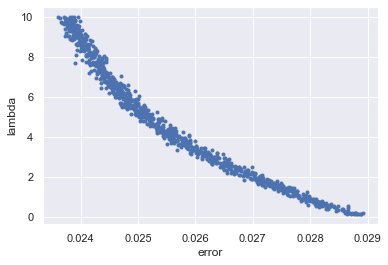

In [177]:
plt.plot(error_vals, np.array(lambdas_test),'.')
plt.xlabel('error')
plt.ylabel('lambda');

Parece que existe una clara relación entre el lambda y el error medido.

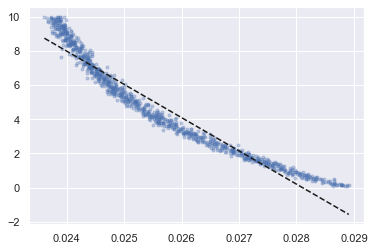

In [274]:
import statsmodels.api as sm

x = error_vals[:,np.newaxis]
y = lambdas_test[:,np.newaxis]

inds = x.ravel().argsort()  # Sort x values and get index    
x = x.ravel()[inds].reshape(-1,1)
y = y[inds] #Sort y according to x sorted index

xc = sm.add_constant(x)
model = sm.OLS(y, xc).fit()
ypred = model.predict(xc) 

plt.plot(x, y, '.', alpha = 0.3)
plt.plot(x, ypred,'k--')

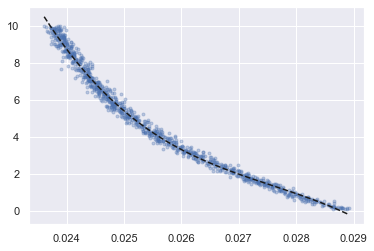

In [276]:
from sklearn.preprocessing import PolynomialFeatures
polynomial_features = PolynomialFeatures(degree=3)
xp = polynomial_features.fit_transform(x)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

plt.plot(x, y,'.', alpha = 0.3)
plt.plot(x, ypred, 'k--');

In [280]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 3.388e+04
Date:                Fri, 26 Jun 2020   Prob (F-statistic):               0.00
Time:                        17:41:42   Log-Likelihood:                -144.97
No. Observations:                1000   AIC:                             297.9
Df Residuals:                     996   BIC:                             317.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1727.1914     63.932     27.016      0.000    1601.734    1852.649
x1         -1.857e+05   7370.488    -25.197      0.000      -2e+05   -1.71e+05
x2          6.698e+06   2.83e+05     23.685      0.000    6.14e+06    7.25e+06
x3         -8.097e+07   3.61e+06    -22.424      0.000   -8.81e+07   -7.39e+07
==============================================================================
Omnibus:                       38.146   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.556
Skew:                          -0.054   Prob(JB):                     3.26e-23
Kurtosis:                       4.573   Cond. No.                     4.09e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.99e-15. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

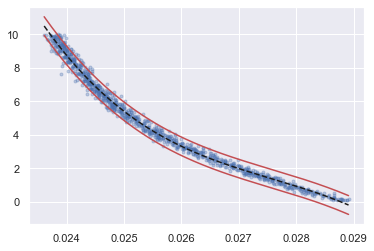

In [285]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, upper,lower = wls_prediction_std(model)

plt.plot(x,y,'.', alpha = 0.3)
plt.plot(x,ypred, 'k--')
plt.plot(x,upper,'r') # confid. intrvl
plt.plot(x,lower,'r');

### Transformando con boxcox

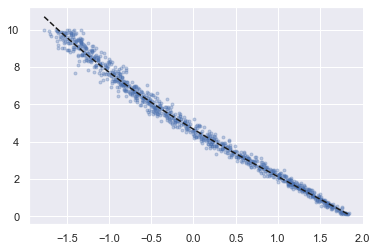

In [303]:
from scipy.stats import boxcox

error_vals_transformed, lambda_boxcox = boxcox(error_vals)
error_vals_transformed_mu = np.mean(error_vals_transformed)
error_vals_transformed_sigma = np.std(error_vals_transformed)
error_vals_transformed_normalized = (error_vals_transformed - error_vals_transformed_mu)/error_vals_transformed_sigma

x = error_vals_transformed_normalized[:,np.newaxis]
y = lambdas_test[:,np.newaxis]

inds = x.ravel().argsort()  # Sort x values and get index    
x = x.ravel()[inds].reshape(-1,1)
y = y[inds] #Sort y according to x sorted index

polynomial_features = PolynomialFeatures(degree = 3)
xp = polynomial_features.fit_transform(x)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

plt.plot(x, y,'.', alpha = 0.3)
plt.plot(x, ypred, 'k--');

In [305]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 3.360e+04
Date:                Fri, 26 Jun 2020   Prob (F-statistic):               0.00
Time:                        17:57:00   Log-Likelihood:                -149.14
No. Observations:                1000   AIC:                             306.3
Df Residuals:                     996   BIC:                             325.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.6644      0.014    342.216      0.000       4.638       4.691
x1            -2.7299      0.022   -123.026      0.000      -2.773      -2.686
x2             0.2617      0.011     24.804      0.000       0.241       0.282
x3            -0.0706      0.012     -6.053      0.000      -0.093      -0.048
==============================================================================
Omnibus:                       44.039   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.305
Skew:                          -0.066   Prob(JB):                     3.07e-29
Kurtosis:                       4.770   Cond. No.                         6.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

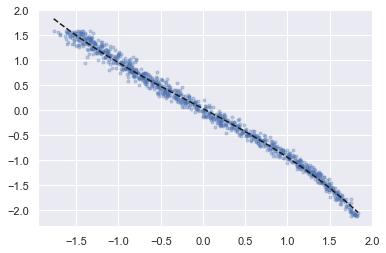

In [322]:
lambdas_test_transformed, lambda_boxcox = boxcox(lambdas_test)
lambdas_test_transformed_mu = np.mean(lambdas_test_transformed)
lambdas_test_transformed_sigma = np.std(lambdas_test_transformed)
lambdas_test_transformed_normalized = (lambdas_test_transformed - lambdas_test_transformed_mu)/lambdas_test_transformed_sigma

x = error_vals_transformed_normalized[:,np.newaxis]
y = lambdas_test_transformed_normalized[:,np.newaxis]

inds = x.ravel().argsort()  # Sort x values and get index    
x = x.ravel()[inds].reshape(-1,1)
y = y[inds] #Sort y according to x sorted index

polynomial_features = PolynomialFeatures(degree = 3)
xp = polynomial_features.fit_transform(x)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp) 

plt.plot(x, y,'.', alpha = 0.3)
plt.plot(x, ypred, 'k--');

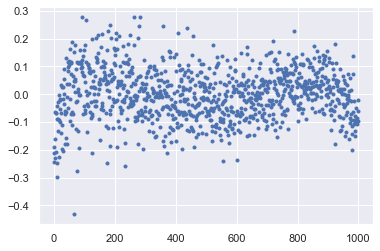

In [323]:
plt.plot(model.resid,'.')

In [324]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                 3.842e+04
Date:                Fri, 26 Jun 2020   Prob (F-statistic):               0.00
Time:                        18:03:59   Log-Likelihood:                 960.98
No. Observations:                1000   AIC:                            -1914.
Df Residuals:                     996   BIC:                            -1894.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0360      0.004      8.025      0.000       0.027       0.045
x1            -0.8903      0.007   -121.765      0.000      -0.905      -0.876
x2            -0.0279      0.003     -8.038      0.000      -0.035      -0.021
x3            -0.0565      0.004    -14.714      0.000      -0.064      -0.049
==============================================================================
Omnibus:                        7.482   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                9.660
Skew:                          -0.069   Prob(JB):                      0.00799
Kurtosis:                       3.461   Cond. No.                         6.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Como varia el error en funcion del tiempo simulado para diferentes lambdas?

Simulemos 7 lambdas (0.1, 0.2, 0.5, 1.0, 2.0, 5.0, y 10) 100 veces cada una por un periodo de 300 segundos, para entender como varia el error en funcion de la longitud de la simulacion

In [403]:
ini_points2 = np.empty((700,2))
for i in range(700):
    ini_points2[i] = create_initial_condition()

lambdas_test2 = 100*[0.1] + 100*[0.2] + 100*[0.5] + 100*[1.0] + 100*[2.0] + 100*[5.0] + 100*[10.0]

o = 1
a = 1
sigma = 0.1
tfin = 300
tstep = 0.01
rs2 = []
for i, l in enumerate(lambdas_test2):
    rs2.append(realization_with_params_time_initial_conditions(l, o, a, l, sigma, ini_points2[i,:], tfin, tstep))

In [404]:
error_dict = {}
mean_dict = {}
std_dict = {}
min_dict = {}
max_dict = {}
for i, traj in enumerate(rs2):
    for points in [1000, 2000, 3000, 5000, 10000, 20000, 30000]:
        error_dict[(i,lambdas_test2[i], points)] = error(target_digitized, digitize(traj[:points,:], bins))
        r = np.sqrt(traj[:points,0]**2 + traj[:points,1]**2)
        mean_dict[(i,lambdas_test2[i], points)] = np.mean(r)
        std_dict[(i,lambdas_test2[i], points)] = np.std(r)
        min_dict[(i,lambdas_test2[i], points)] = np.min(r)
        max_dict[(i,lambdas_test2[i], points)] = np.max(r)

In [405]:
error_df = []
for i in error_dict.keys():
    error_df.append([i[0],i[1],i[2]*0.01, error_dict[i], mean_dict[i], std_dict[i], min_dict[i], max_dict[i]])
error_df = pd.DataFrame(error_df)
error_df.columns = ['traj', 'lambda', 'time', 'error', 'mean', 'std', 'min', 'max']

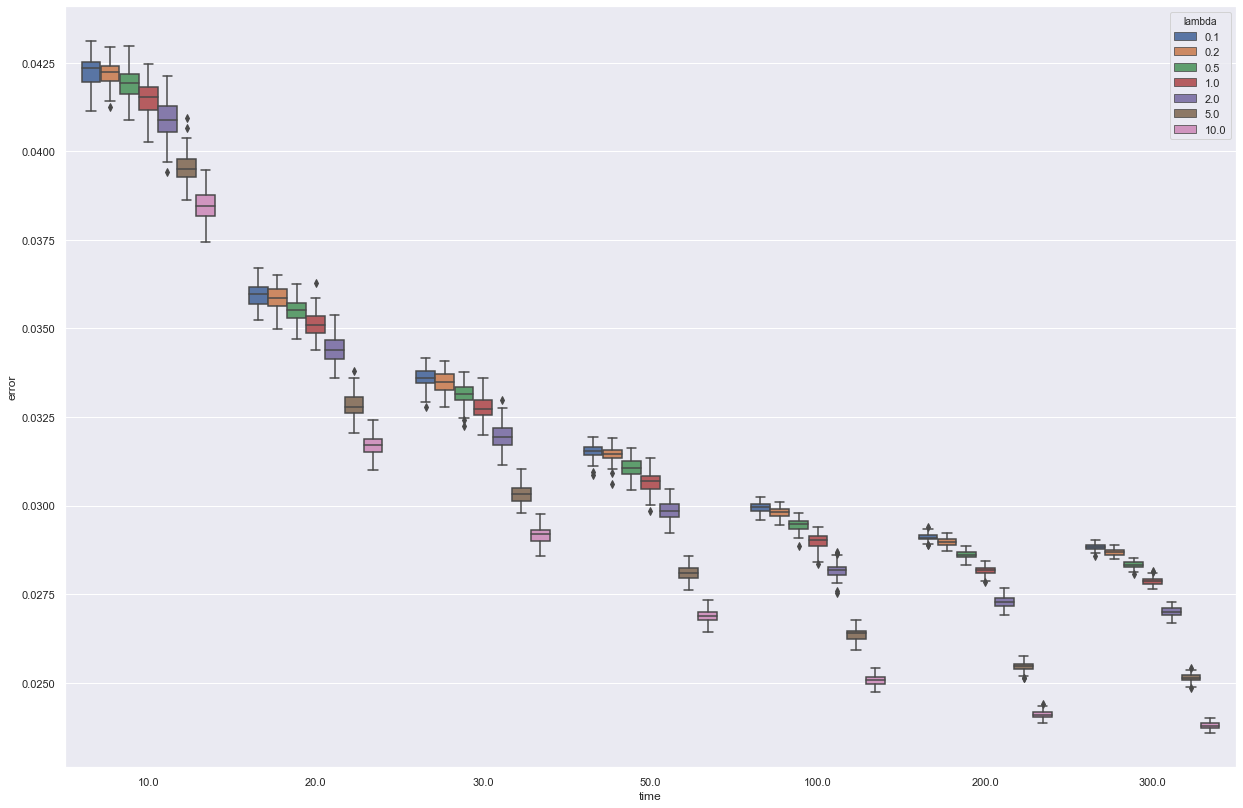

In [406]:
plt.figure(figsize = (21,14))
sns.boxplot(data = error_df, x = 'time', y = 'error', hue = 'lambda')

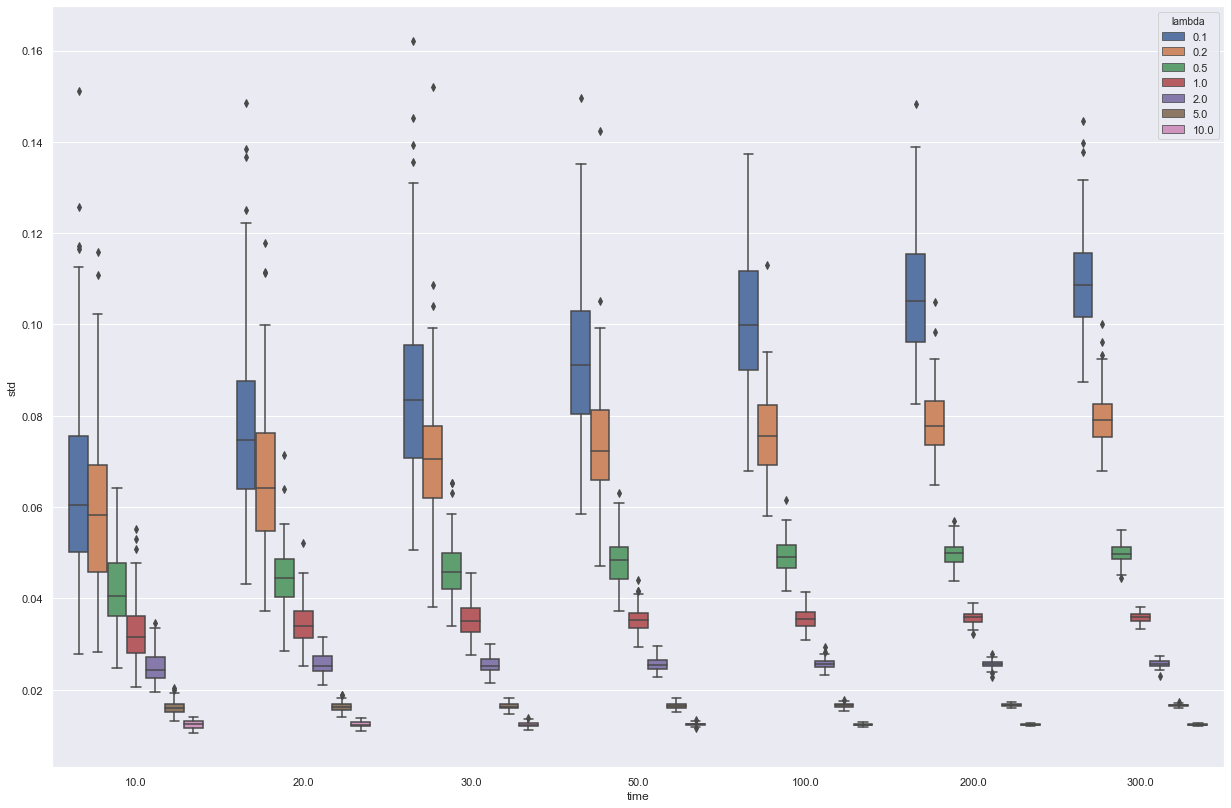

In [407]:
plt.figure(figsize = (21,14))
sns.boxplot(data = error_df, x = 'time', y = 'std', hue = 'lambda')

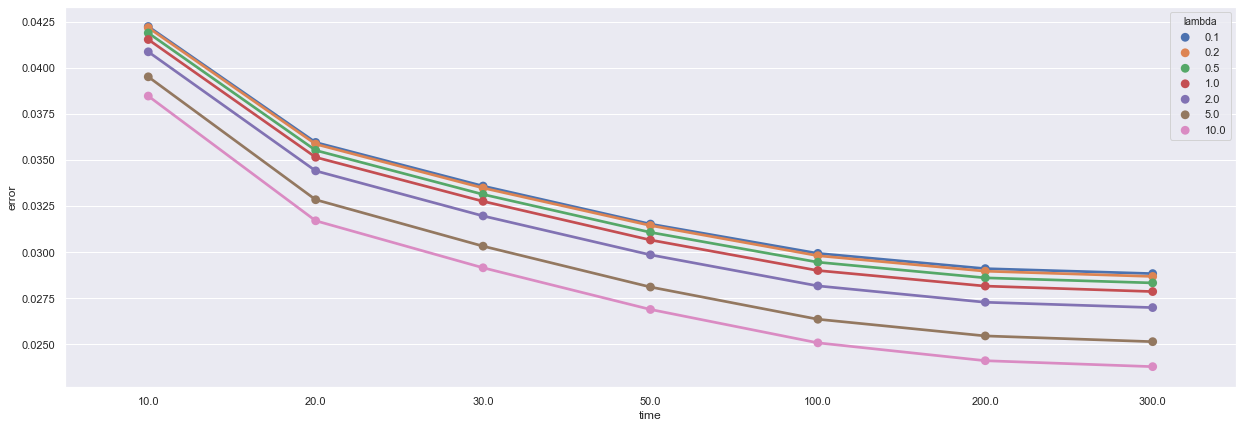

In [408]:
plt.figure(figsize = (21, 7))
sns.pointplot(data = error_df, x = 'time', y = 'error', hue='lambda')

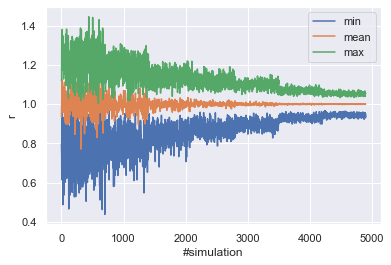

In [414]:
plt.plot(error_df['min'], label = 'min')
plt.plot(error_df['mean'], label = 'mean')
plt.plot(error_df['max'], label = 'max')
plt.xlabel('#simulation')
plt.ylabel('r')
plt.legend()

Vamos ver si es posible clasificar la trayectoria en función de los parámetros medidos a diferentes tiempos